[*********************100%***********************]  1 of 1 completed


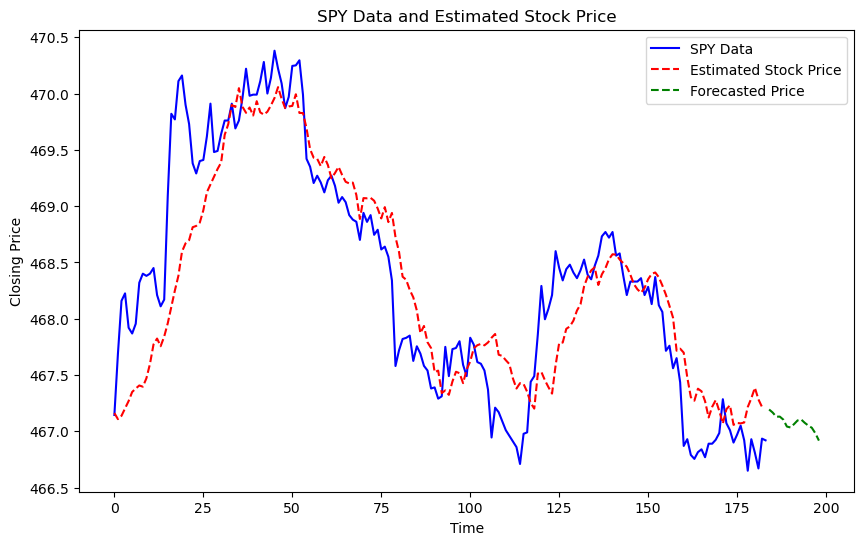

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical SPY data from Yahoo Finance
spy_data = yf.download('SPY', period='400', interval = '2m')['Adj Close'].values

class ParticleFilter:
    def __init__(self, N, state_dim, prediction_model, observation_model):
        self.N = N
        self.state_dim = state_dim
        self.prediction_model = prediction_model
        self.observation_model = observation_model

        self.particles = np.random.randn(N, state_dim)
        self.weights = np.ones(N) / N

    def predict(self, lagged_price):
        for i in range(self.N):
            # Predict the stock price for the next day using an AR(1) model
            self.particles[i] = self.prediction_model(self.particles[i], lagged_price)

    def update(self, observation):
        # Update the particle filter with the observed stock price for the next day
        for i in range(self.N):
            # Calculate the likelihood of the observation
            self.weights[i] *= self.observation_model(self.particles[i], observation)

        # Normalize the weights
        self.weights /= np.sum(self.weights)

    def resample(self, N):
        # Resample the particles
        indexes = np.random.choice(np.arange(N), size=N, p=self.weights)
        self.particles = self.particles[indexes]
        self.weights = np.ones(N) / N

    def estimate(self, axis=0):
        # Estimate the stock price for the next day
        return np.average(self.particles, weights=self.weights, axis=axis)

    def forecast(self, num_days=15, historical_data=None):
        # Generate forecasts for the specified number of days using the actual historical data
        forecasts = []
        for i in range(num_days):
            # Predict the stock price for the next day using the lagged price from actual data
            lagged_price = historical_data[-1] if historical_data is not None else self.particles[:, 0][-1]
            self.predict(lagged_price)

            # Estimate the stock price for the next day using the last observed price
            forecasted_price = self.estimate()
            forecasts.append(forecasted_price)

        return forecasts

# Create a particle filter with 1000 particles
particle_filter = ParticleFilter(N=1000, state_dim=1, prediction_model=lambda x, lagged_price: 0.9 * x + 0.1 * lagged_price + np.random.randn(), observation_model=lambda x, y: 1.0)

# Initialize the particle filter with the initial stock price
particle_filter.particles[:, 0] = spy_data[0] + np.random.randn(1000) * 1.0

# Lists to store estimated prices for each day
estimated_prices = []

# Update the particle filter for each day in the dataset
for t in range(1, len(spy_data)):
    # Predict the stock price for the next day using the lagged price from actual data
    particle_filter.predict(spy_data[t - 1])

    # Update the particle filter with the observed stock price for the next day
    particle_filter.update(spy_data[t])

    # Resample the particles
    particle_filter.resample(N=1000)

    # Estimate the stock price using the last observed price
    estimated_price = particle_filter.estimate()
    estimated_prices.append(estimated_price)

# Forecast the stock price for the next 5 days using the actual historical data
forecasts = particle_filter.forecast(num_days=15, historical_data=spy_data)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(spy_data, label='SPY Data', color='blue')
plt.plot(estimated_prices, label='Estimated Stock Price', color='red', linestyle='--')
plt.plot(np.arange(len(spy_data), len(spy_data) + len(forecasts)), forecasts, label='Forecasted Price', color='green', linestyle='--')
plt.title('SPY Data and Estimated Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
